In [75]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
# Load the data using laspy
#inFile_cloud = File('../../Data/164239/10552_NYU_M2 - Scanner 1 - 190511_164239_1 - originalpoints.las', mode='r')
inFile_fwf = File('../../Data/164239/10552_NYU_M2 - Scanner 1 - 190511_164239_1 - originalpoints.las', mode='r')

# raw is a 1-D numpy array, each entry is a point
#raw_cloud = inFile_cloud.get_points()
raw_fwf = inFile_fwf.get_points()
#print("Number of points, point cloud: ",len(raw_cloud))
print("Number of points, full waveform: ",len(raw_fwf))

Number of points, full waveform:  14542329


In [3]:
# Corresponds to LAS 1.4 Point Data Record Format 9
# X coordinate of the point (must be adjusted by offset and scale factor)
columns_fwf =[ 
    'X', 
    'Y',
    'Z',
    'intensity', #Intensity of the return, scaled to a 0-65,535 scale
    'flag_byte', #Return number, # of returns, Scan direction flag (+ or -), Edge of flight line flag
    'classification_flags', #Only if the point has been classified: vegetation, etc.
    'classification_byte', #Various flags about the point
    'user_data', 
    'scan_angle', # Down is 0.0, each unit is 0.006 degrees, 
    #so value between -30,000 and 30,000, or (180deg/0.006deg)
    #Spec says this incorporates the roll of the aircraft
    'pt_src_id', #Unique ID for the source of the point
    'gps_time', #GPS Week Time (seconds, reset each week) or Adj Std GPS Time
    'wave_packet_desc_index', # Indicates which waveform packet descriptor is applied.
    'byte_offset_to_waveform_data', # Locates the WF data in EVLR or .wdp file.
    'wavefm_pkt_size', # Size of the waveform packet
    'return_point_waveform_loc', # Time in picoseconds 
    'x_t', # Form parametric location: X = X_0 + x_t*t
    'y_t', # (X_0,Y_0,Z_0) is the anchor point associated with the waveform
    'z_t' ]

# Corresponds to LAS 1.4 Point Data Record Format 6
columns_point_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

In [112]:
def raw_to_df(raw,column_names):
    '''function takes raw output of laspy.File.get_points() and column names, and returns a pandas Dataframe'''
    raw_list = [a[0].tolist() for a in raw]
    df = pd.DataFrame(raw_list,columns = column_names)
    return df

def scale_and_offset(df,header,append_to_df=False):
    '''Function takes as input the dataframe output of raw_to_df and the laspy header file.
       Output is a nx3 dataframe with adjusted X,Y, and Z coordinates, from the formula: 
       X_adj = X*X_scale + X_offset.
       Brooklyn LiDAR readings appear to be in feet, and use NAVD 88 in the vertical and 
       New York Long Island State Plane Coordinate System NAD 33 in the horizontal.'''
    offset = header.offset
    scale = header.scale
    scaled_xyz = df[['X','Y','Z']]*scale + offset
    if append_to_df:
        df['x_scaled'] = scaled_xyz['X']
        df['y_scaled'] = scaled_xyz['Y']
        df['z_scaled'] = scaled_xyz['Z'] 
        return df
    else:
        return scaled_xyz

#INACTIVE FUNCTIONS
def split_and_strip(raw):
    '''Function takes the output ndarray of laspy File.get_points(), 
        splits each point on commas, 
        outputs a list of lists.'''
    output_list = []
    for row in raw:
        stripped = [a.strip("( , )") for a in str(row).split(',')]
        output_list.append(stripped)
    return output_list

def row_clean(string_list):
    '''Function takes as input a list of lists, the output of split_and_strip().  Cleans the entries for spaces,
    returns a numpy array where each row is a point.'''
    output_list = []
    for row in string_list:        
        output_list.append(list(map(float,row[:-1])))
    output_arr = np.array(output_list)
    return output_arr


In [ ]:
# Create dataframes for point cloud and fwf
#df_fwf = raw_to_df(raw_fwf,columns_fwf)
#df_fwf = raw_to_df(raw_fwf,columns_fwf)

# Generate adjusted coordinates for point cloud.  FWF is identical.
las_points = scale_and_offset(df_fwf,inFile_fwf.header,append_to_df=True)

In [5]:
#las_points.to_pickle("../../Data/pickles/las_points_164239.pkl")
las_points = pd.read_pickle("../../Data/pickles/las_points_164239.pkl")

## Nearby Points
Looking at points around the end of the scan angle (nearby_df), as well points near the middle of the scan angle, directly down (down_df).  There seems to be some noise in the points at the end of the scan angle.

In [88]:
# A handful of points at the end of the scan angle
nearby_points = list(range(32645,32653))+list(range(33760,33767))+list(range(34870,34877))
nearby_df = las_points.iloc[nearby_points]
# Time range
print("Time range: ",nearby_df['gps_time'].max() - nearby_df['gps_time'].min())

Time range:  0.01502318200073205


In [110]:
# Filter for points between -1 and 1 degrees scan angle
down_df = las_points[(las_points['scan_angle']<60)&(las_points['scan_angle']>-60)]

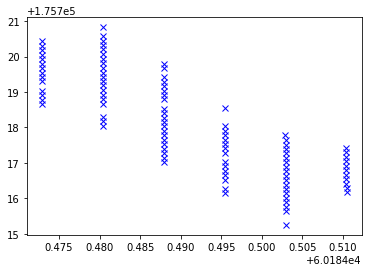

In [109]:
#Helicopter scan lines
plt.plot(down_df['gps_time'][10000:10100],down_df['y_scaled'][10000:10100],'xb')

In [87]:
nearby_df[['x_scaled','y_scaled','z_scaled']]

,x_scaled,y_scaled,z_scaled
32645,977635.746,176002.241,13.829
32646,977637.851,176001.788,10.914
32647,977638.523,176001.617,10.893
32648,977639.244,176001.435,10.899
32649,977638.468,176001.555,13.723
32650,977639.118,176001.385,13.838
32651,977639.887,176001.199,13.546
32652,977641.180,176000.908,12.255
33760,977639.160,176001.219,10.863
33761,977638.478,176001.316,13.584
